In [77]:
import numpy as np
from Bio import pairwise2, SeqIO
from enum import Enum
import random
import matplotlib.pyplot as plt
from fpdf import FPDF 

## Basic Initialziation

In [78]:
class PDF(FPDF):
    
    def lines(self):
        self.set_fill_color(32.0, 47.0, 250.0) # color for outer rectangle
        self.rect(5.0, 5.0, 200.0,287.0,'DF')
        self.set_fill_color(255, 255, 255) # color for inner rectangle
        self.rect(8.0, 8.0, 194.0,282.0,'FD')
    def titles(self):
        self.set_xy(0.0,0.0)
        self.set_font('Arial', 'B', 16)
        self.set_text_color(220, 50, 50)
        self.cell(w=210.0, h=40.0, align='C', txt="Needleman-Wunch Alg GRASP results", border=0)
    def charts(self,plt,x,y):
        self.set_xy(x,y)
        self.image(plt,  link='', type='', w=700/5, h=450/5)
    def texts(self,name):
        with open(name,'rb') as xy:
            txt=xy.read().decode('latin-1')
        self.set_xy(10.0,80.0)    
        self.set_text_color(76.0, 32.0, 250.0)
        self.set_font('Arial', '', 12)
        self.multi_cell(0,10,txt)

In [79]:
class op(Enum):
    GAP_A = 1
    GAP_B = 2
    MA_MM = 3

In [80]:
score_mtx = np.repeat(-1, (5) * (5)).reshape(5, 5)
for i in range(0,5):
    score_mtx[i][i]=1
score_mtx

array([[ 1, -1, -1, -1, -1],
       [-1,  1, -1, -1, -1],
       [-1, -1,  1, -1, -1],
       [-1, -1, -1,  1, -1],
       [-1, -1, -1, -1,  1]])

In [81]:
def init_ops_matrix(sizeA,sizeB):
    matrix = np.repeat(0, (sizeA+1) * (sizeB+1)).reshape(sizeA+1, sizeB+1)
    
    for i in range(1,sizeB+1):
        matrix[0][i] = op.GAP_A.value
    for j in range(1,sizeA+1):
        matrix[j][0] = op.GAP_B.value
    return matrix

In [82]:
def parseNucleotide(nucleotide):
    switcher = {
        'A': 0,
        'T': 1,
        'G': 2,
        'C': 3,
        'N': 4
    }
    return switcher.get(nucleotide,"Invalid nucleotide")

In [83]:
def get_score(score_mtx,characterA,characterB):
        indexA = parseNucleotide(characterA)
        indexB = parseNucleotide(characterB)
        return score_mtx[indexA,indexB]

## Neddleman-Wunch Simple

In [84]:
def traceback(ops_matrix, seqA, seqB):
    seqA_alineada = []
    seqB_alineada = []
    i = len(seqA)
    j = len(seqB)
    while i > 0 or j > 0:
        if ops_matrix[i, j] == op.GAP_A.value:
            seqA_alineada.append("-")
            seqB_alineada.append(seqB[j -1])
            j -= 1
        elif ops_matrix[i, j] == op.GAP_B.value:
            seqB_alineada.append("-")
            seqA_alineada.append(seqA[i -1])
            i -= 1
        else: # es decir, match / mismatch
            i -= 1
            j -= 1
            seqA_alineada.append(seqA[i])
            seqB_alineada.append(seqB[j])
            
    seqA_alineada = seqA_alineada[::-1]
    seqB_alineada = seqB_alineada[::-1]
    
    return seqA_alineada, seqB_alineada

In [85]:
def nw_basic(seqA_str, seqB_str, score_mtx, gap_score = 0):
    sizeA = len(seqA_str)
    sizeB = len(seqB_str)
    sol_matrix = np.repeat(0, (sizeA+1) * (sizeB+1)).reshape(sizeA+1, sizeB+1)
    ops_matrix = init_ops_matrix(sizeA,sizeB)
    
    for i in range(1,sizeA+1):
        for j in range(1,sizeB+1):
            
            diagonal_score = get_score(score_mtx,seqA_str[i-1],seqB_str[j-1])
            diagonal_result = sol_matrix[i-1][j-1] + diagonal_score
            left_result = sol_matrix[i][j-1] + gap_score
            above_result = sol_matrix[i-1][j] + gap_score
            results = [diagonal_result,left_result,above_result]
            result_index = np.argmax(results)
            if result_index == 0:
                sol_matrix[i][j] = diagonal_result
                ops_matrix[i][j] = op.MA_MM.value
            elif result_index == 1:
                sol_matrix[i][j] = left_result
                ops_matrix[i][j] = op.GAP_A.value
            else:
                sol_matrix[i][j] = above_result
                ops_matrix[i][j] = op.GAP_B.value

    aln_a, aln_b = traceback(ops_matrix,seqA_str,seqB_str)

    profile = Profile()
    profile.add_seq(aln_a,sol_matrix[sizeA, sizeB])
    profile.add_seq(aln_b,sol_matrix[sizeA, sizeB])
    
    return profile

## Profile

In [86]:
class Profile:
    def __init__(self):
        self.alignment_dashboard = {"A":{},"T":{},"G":{},"C":{},"N":{},"-":{}}
        self.score=0
        self.elems_per_col=0
        self.size = 0
        self.seqs = []

    def calculate_score_at(self,index,score_matrix,gap_score):
        nucleotides = []
        score = 0
        for seq in self.seqs:
            try:
                nucleotides.append(seq[index])
            except IndexError:
                print("seq", len(seq))
                print("index", index)
        for x in range(len(nucleotides)):
            for y in range(x+1,len(nucleotides)):
                first= nucleotides[x]
                second= nucleotides[y]
                if not (first == "-" and second == "-"):
                    if first == "-" or second == "-":
                        score+=gap_score
                    else:
                        score+= get_score(score_matrix,first,second)
        return score
                        
                
    def columnAt(self,index):
        a = self.alignment_at("A",index)
        t = self.alignment_at("T",index)
        g = self.alignment_at("G",index)
        c = self.alignment_at("C",index)
        n = self.alignment_at("N",index)
        gap = self.alignment_at("-",index)
        return {"A":a,"T":t,"G":g,"C":c,"N":n,"-":gap}
    def alignment_at(self,nucleotide,index):
        res = 0
        try:
            res =self.alignment_dashboard[nucleotide][index]
        except KeyError:
            return res
        return res
    def traceback(self,ops_matrix,seq):
        gaps_profile=[]
        seq_alineada = []
        i = len(seq)
        j = self.size
        while i > 0 or j > 0:
            if ops_matrix[i, j] == op.GAP_A.value:
                seq_alineada.append("-")
                j -= 1
            elif ops_matrix[i, j] == op.GAP_B.value:
                gaps_profile.append(i -1)
                seq_alineada.append(seq[i -1])
                i -= 1
            else: # es decir, match / mismatch
                i -= 1
                j -= 1
                seq_alineada.append(seq[i])
            
        seq_alineada = seq_alineada[::-1]

        return seq_alineada,gaps_profile
        
    def apply_gaps(self,gaps_positions):
        self.alignment_dashboard = {"A":{},"T":{},"G":{},"C":{},"N":{},"-":{}}
        self.elems_per_col=0
        new_aligned_seq=[]
        for seq in self.seqs:
            aligned_seq=[]
            for index in range(len(seq)):
                if index in gaps_positions:
                    aligned_seq.append("-")
                aligned_seq.append(seq[index])
            
            new_aligned_seq.append(aligned_seq) 
        self.seqs=[]
        for seq in new_aligned_seq:
            self.add_seq(seq,self.score)
    def add_seq(self,aligned_sequense,score):
        for index in range(len(aligned_sequense)):
            actual_character = aligned_sequense[index]
            
            try:
                actual_charater_count = self.alignment_dashboard[actual_character][index]
            except KeyError:
                self.alignment_dashboard[actual_character][index] = 0
                actual_charater_count = self.alignment_dashboard[actual_character][index] 
            self.alignment_dashboard[actual_character][index] = actual_charater_count + 1
            self.size = max(self.size, len(aligned_sequense))
        self.seqs.append( aligned_sequense)   
        self.elems_per_col+=1
        self.score = score
    

## Needleman-Wunch MSA

In [87]:
def nw_msa(seqs,score_mtx, gap_score = 0):
    if len(seqs) == 1 or len(seqs) == 0:
        return
    seq_a = seqs.pop(0)
    seq_b = seqs.pop(0)
    profile = nw_basic(seq_a,seq_b,score_mtx, gap_score)
    for seq in seqs:
        profile,aligned_seq, score,gaps_profile =nw_msa_util(seq,profile,score_mtx,gap_score)
        profile.apply_gaps(gaps_profile)
        profile.add_seq(aligned_seq,score)
    return profile
    

In [88]:
def nw_msa_util(seq, profile,score_mtx,gap_score):
    sizeA = len(seq)
    sizeB = profile.size
    sol_matrix = np.repeat(0.0, (sizeA+1) * (sizeB+1)).reshape(sizeA+1, sizeB+1)
    ops_matrix = init_ops_matrix(sizeA,sizeB)
    
    for i in range(1,sizeA+1):
        for j in range(1,sizeB+1):
            col=profile.columnAt(j-1)
            nucleotide = seq[i-1]
            
            diagonal_score = get_score_prof(score_mtx,gap_score,nucleotide,col,profile.elems_per_col)
            diagonal_result = sol_matrix[i-1][j-1] + diagonal_score
            
            left_result = sol_matrix[i][j-1] + get_score_prof_gap(gap_score,"-",col,profile.elems_per_col)
            
            above_result = sol_matrix[i-1][j] + get_score_prof_gap(gap_score,nucleotide,"-",profile.elems_per_col)
            
            results = [diagonal_result,left_result,above_result]
           
            result_index = np.argmax(results)

            if result_index == 0:
                sol_matrix[i][j] = diagonal_result
                ops_matrix[i][j] = op.MA_MM.value
            elif result_index == 1:
                sol_matrix[i][j] = left_result
                ops_matrix[i][j] = op.GAP_A.value
            else:
                sol_matrix[i][j] = above_result
                ops_matrix[i][j] = op.GAP_B.value
 
    aligned_seq,gaps_profile = profile.traceback(ops_matrix,seq)

    return profile, aligned_seq, sol_matrix[sizeA, sizeB],gaps_profile

In [89]:
def get_score_prof(score_mtx,gap_score,char,column,total_per_column):
    score =0
    for k,v in column.items():
        if k!= "-":
            value= (v/total_per_column)*get_score(score_mtx,char,k)
        else:
            value=(v/total_per_column)*gap_score
        score += value
    return score

In [90]:
def get_score_prof_gap(gap_score,char,column,total_per_column):
    score = 0
    if column == "-":
        return total_per_column * gap_score
    for k,v in column.items():
        if k != "-" and char == "-":
            score += (v/total_per_column)*gap_score
    return score

## GRASP

In [91]:
def generate_random_solution_with_profile(seqs,profile,score_matrix,gap_score=0):
    while len(seqs) != 0:
        size = len(seqs)
        solutions=[]
        for seq in seqs:
            prof, aligned_seq, score,gaps_profile=nw_msa_util(seq, profile,score_matrix,gap_score)
            solutions.append((aligned_seq, score,gaps_profile,seq))
        solutions.sort(key=lambda x:x[1], reverse=True)
        first=0
        last = size-1
        mid= (size//2) if size>1 else 0
        aligned_seq, score,gaps_profile,original_seq = solutions[random.choice([first,mid,last])]
        profile.apply_gaps(gaps_profile)
        profile.add_seq(aligned_seq,score)
        seqs.remove(original_seq)
    return profile

In [92]:
def generate_random_solution(seqs,score_matrix,gap_score=0):
    size = len(seqs)
    solutions = []
    for row in range(size):
        for col in range(row+1,size):
            seq_a = seqs[row]
            seq_b = seqs[col]
            solutions.append((nw_basic(seq_a,seq_b,score_mtx,0),seq_a,seq_b))
    solutions.sort(key=lambda x:x[0].score, reverse=True)
    first=0
    last = size-1
    mid= (size//2)  if size>1 else 0
    random_index = random.choice([first,mid,last])
    profile,seq_a,seq_b = solutions[random_index]
    seqs.remove(seq_a)
    seqs.remove(seq_b)
    return generate_random_solution_with_profile(seqs,profile,score_matrix,gap_score)    

In [93]:
def look_for_better_solution(profile,score_matrix,gap_score,max_iterations):

    max_results_per_it = {}
    max_results_per_it[0]= (0,profile.score,profile)
    for actual_it in range(1,max_iterations+1):
        local_max_profiles= []
        for index in range(len(profile.seqs)):
            iter_changes = local_max_from_neighbourhood(index,profile,score_matrix,gap_score,max_iterations)
            local_max_profiles.append(iter_changes)
        max_results_per_it[actual_it] = local_max_profiles[len(local_max_profiles)-1]   
    return max_results_per_it

In [94]:
def local_max_from_neighbourhood(seq_index,profile,score_matrix,gap_score,max_iterations):
   
    actual_seq = profile.seqs[seq_index]
    changes = []
    for index in range(len(actual_seq)-1):
                
            first = actual_seq[index]
            second = actual_seq[index+1]
            if ((first == "-" or second == "-") and first!=second):
                new_seq = actual_seq[:index]
                new_seq.append(second)
                new_seq.append(first)
                new_seq += actual_seq[index+2:]
                first_score = profile.calculate_score_at(index,score_matrix,gap_score)
                second_score = profile.calculate_score_at(index+1,score_matrix,gap_score)
                    
                profile.seqs[seq_index] = new_seq
                new_first_score = profile.calculate_score_at(index,score_matrix,gap_score)
                new_second_score = profile.calculate_score_at(index+1,score_matrix,gap_score)
                profile.seqs[seq_index] = actual_seq
                diff= new_first_score + new_second_score - first_score -second_score
                if (diff>0):
                    changes.append((index,index+1,new_seq,diff))
                    
                    
    if len(changes)>0:
        change = max(changes, key=lambda p: p[3])
        profile.seqs[seq_index] = change[2]
        profile.score = profile.score +  change[3]
        return (change[3],profile.score,profile)
    else:
        return (0,profile.score,profile)

In [95]:
def grasp(seqs,score_matrix,gap_score,max_iterations):
    p=generate_random_solution(seqs,score_mtx,gap_score)
    return look_for_better_solution(p,score_matrix,gap_score,max_iterations)

### Seqs from fasta

In [96]:
seqs = []
f_aln = SeqIO.parse("x.fasta", 'fasta')

while(True):
    try:
        elem = next(f_aln)
        seq = str(elem.seq)
        seqs.append(seq)
    except StopIteration:
        break

## Executing

In [97]:
result=grasp(seqs,score_mtx,0,20)
result

{0: (0, 102.5, <__main__.Profile at 0x7ff82e15ea60>),
 1: (6, 125.5, <__main__.Profile at 0x7ff82e15ea60>),
 2: (6, 145.5, <__main__.Profile at 0x7ff82e15ea60>),
 3: (5, 164.5, <__main__.Profile at 0x7ff82e15ea60>),
 4: (5, 185.5, <__main__.Profile at 0x7ff82e15ea60>),
 5: (5, 206.5, <__main__.Profile at 0x7ff82e15ea60>),
 6: (5, 223.5, <__main__.Profile at 0x7ff82e15ea60>),
 7: (5, 240.5, <__main__.Profile at 0x7ff82e15ea60>),
 8: (5, 257.5, <__main__.Profile at 0x7ff82e15ea60>),
 9: (5, 275.5, <__main__.Profile at 0x7ff82e15ea60>),
 10: (5, 291.5, <__main__.Profile at 0x7ff82e15ea60>),
 11: (5, 306.5, <__main__.Profile at 0x7ff82e15ea60>),
 12: (6, 322.5, <__main__.Profile at 0x7ff82e15ea60>),
 13: (5, 336.5, <__main__.Profile at 0x7ff82e15ea60>),
 14: (4, 349.5, <__main__.Profile at 0x7ff82e15ea60>),
 15: (5, 363.5, <__main__.Profile at 0x7ff82e15ea60>),
 16: (4, 375.5, <__main__.Profile at 0x7ff82e15ea60>),
 17: (4, 387.5, <__main__.Profile at 0x7ff82e15ea60>),
 18: (4, 401.5, <__m

In [98]:
iterations = []
incs = []
scores = []
for k,t in result.items():
    (inc,score,prof) = t
    iterations.append(k)
    scores.append(score)
    incs.append(inc)
    profile = prof

### Wrting aligned seqs to file

In [107]:
with open('seqs.txt', 'w') as f:
    index = 1
    for line in profile.seqs:
        str_line= ''.join(line)
        f.write(f'Aligned sequense {index}:')
        f.write('\n')
        f.write(str_line)
        f.write('\n')
        index += 1

### Drawing score increments over iterations and saveing to PNG

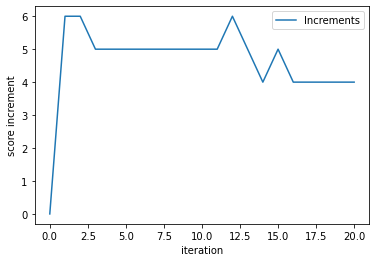

In [108]:
plt.plot(iterations, incs, label = 'Increments')
plt.xlabel('iteration')
plt.ylabel('score increment')
plt.legend()
plt.savefig('chart1.png')

### Drawing scores over iterations and saveing to PNG

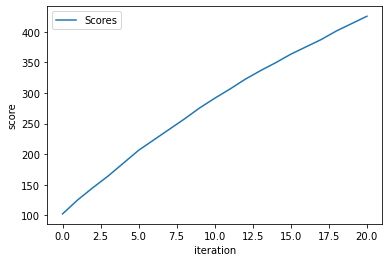

In [109]:
plt.plot(iterations, scores, label = 'Scores')
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.savefig('chart2.png')

### Writing SEQS and plots to PDF

In [110]:
pdf = PDF(orientation='P', unit='mm', format='A4')

In [111]:
pdf.add_page()
pdf.lines()
pdf.titles()
pdf.charts('chart1.png',40.0,25.0)
pdf.charts('chart2.png',40.0,100.0)
pdf.add_page()
pdf.texts('seqs.txt')
pdf.output('out.pdf','F')

''